<a href="https://colab.research.google.com/github/hprasad99/Deep-Learning/blob/master/camvid_tiramisu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/alexgkendall/SegNet-Tutorial.git

Cloning into 'SegNet-Tutorial'...
remote: Enumerating objects: 2785, done.
remote: Total 2785 (delta 0), reused 0 (delta 0), pack-reused 2785
Receiving objects: 100% (2785/2785), 340.84 MiB | 46.94 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

In [8]:
path = Path('SegNet-Tutorial/CamVid')

In [9]:
path.ls()

[PosixPath('SegNet-Tutorial/CamVid/test.txt'),
 PosixPath('SegNet-Tutorial/CamVid/testannot'),
 PosixPath('SegNet-Tutorial/CamVid/train'),
 PosixPath('SegNet-Tutorial/CamVid/val'),
 PosixPath('SegNet-Tutorial/CamVid/valannot'),
 PosixPath('SegNet-Tutorial/CamVid/train.txt'),
 PosixPath('SegNet-Tutorial/CamVid/test'),
 PosixPath('SegNet-Tutorial/CamVid/trainannot'),
 PosixPath('SegNet-Tutorial/CamVid/val.txt')]

In [10]:
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('SegNet-Tutorial/CamVid/val/0016E5_08079.png'),
 PosixPath('SegNet-Tutorial/CamVid/val/0016E5_08005.png'),
 PosixPath('SegNet-Tutorial/CamVid/val/0016E5_08045.png')]

In [11]:
lbl_names = get_image_files(path/'valannot')
lbl_names[:3]

[PosixPath('SegNet-Tutorial/CamVid/valannot/0016E5_08079.png'),
 PosixPath('SegNet-Tutorial/CamVid/valannot/0016E5_08005.png'),
 PosixPath('SegNet-Tutorial/CamVid/valannot/0016E5_08045.png')]

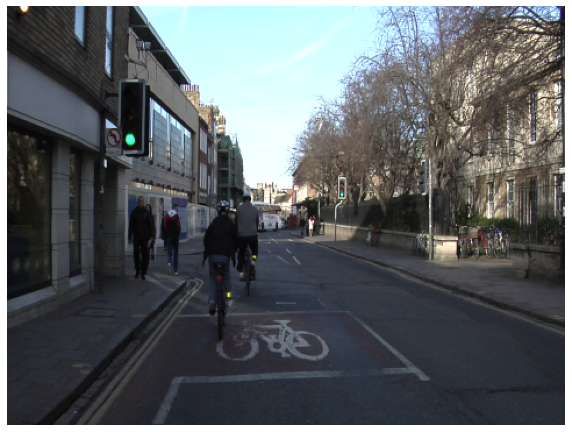

In [13]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(10,10))

In [14]:
def get_y_fn(x):
  return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky','Building','Pole','Road','Sidewalk','Tree','Sign','Fence','Car','Pedestrain','Cyclist','Void'])

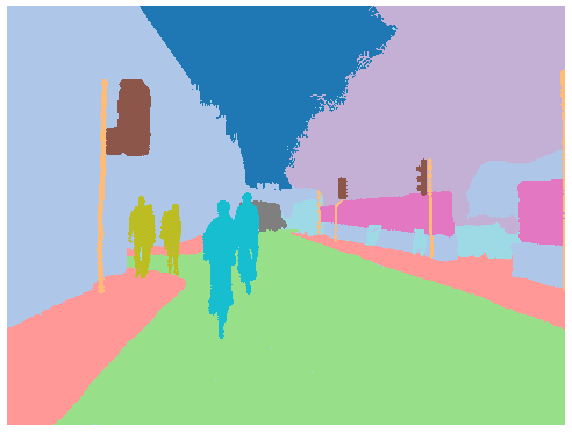

In [19]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(10,10),alpha=1)

In [20]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([360, 480]), tensor([[[1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          ...,
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3]]]))

In [21]:
bs,size = 8,src_size//2

In [22]:
src = (SegmentationItemList.from_folder(path).split_by_folder(valid='val').label_from_func(get_y_fn,classes=codes))

In [23]:
data = (src.transform(get_transforms(),tfm_y=True)
        .databunch(bs=bs,num_workers=0)
        .normalize(imagenet_stats))

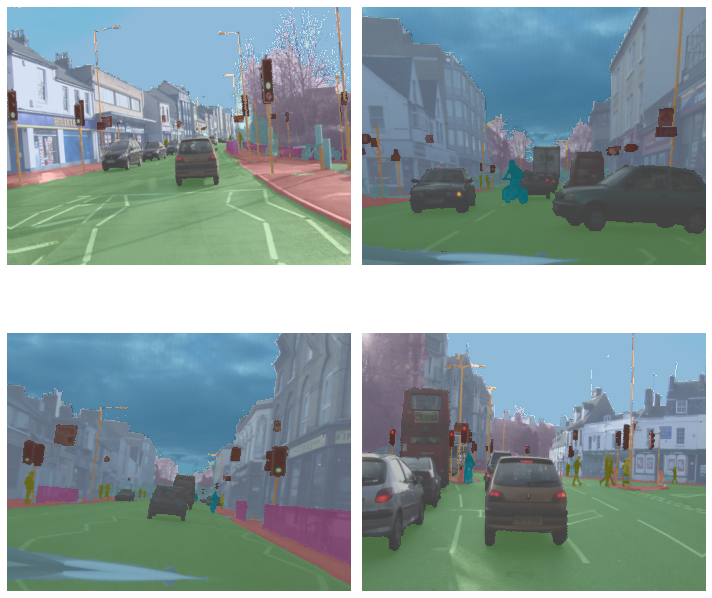

In [24]:
data.show_batch(2,figsize=(10,10))

In [25]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input,target):
  target = target.squeeze(1)
  mask = target !=void_code
  return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [26]:
metrics = acc_camvid
wd = 1e-2

In [28]:
learn = unet_learner(data,models.resnet34,metrics=metrics,wd=wd,model_dir='/tmp/models')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


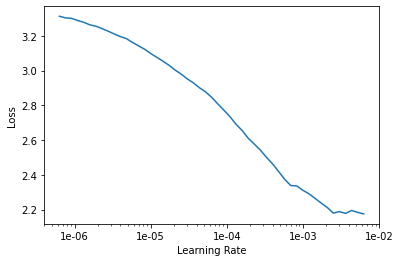

In [30]:
lr_find(learn)
learn.recorder.plot()

In [31]:
lr = 2e-3

In [32]:
learn.fit_one_cycle(10,slice(lr),pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.223491,0.889487,0.758510,01:07
1,0.823627,0.642555,0.792934,01:05
2,0.629429,0.496011,0.864482,01:05
3,0.523296,0.533536,0.849036,01:05
4,0.530999,0.758065,0.738232,01:04
5,0.604154,0.489659,0.854064,01:04
6,0.517514,0.373716,0.892803,01:04
7,0.463534,0.417464,0.876625,01:04
8,0.427183,0.350619,0.903276,01:04
9,0.365266,0.303817,0.904940,01:04


In [33]:
learn.save('stage-1')

In [34]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (367 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: SegNet-Tutorial/CamVid;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: SegNet-Tutorial/CamVid;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

In [35]:
learn.unfreeze()

In [36]:
lrs = slice(lr/100,lr)

In [ ]:
learn.fit_one_cycle(12,lrs,pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.300696,0.302498,0.904081,01:06
1,0.292917,0.293955,0.907567,01:06
2,0.288219,0.278295,0.916048,01:06
3,0.288152,0.304555,0.897157,01:06
4,0.292528,0.338578,0.890678,01:06


In [ ]:
learn.save('stage-2')